# Group Optimization

## import

In [99]:
import openjij as oj
from pyqubo import Binary, Constraint
import numpy as np
import itertools
import matplotlib.pyplot as plt

## Parameters

In [ ]:
n_verts = 9
n_groups = 3
n_group_verts = n_verts // n_groups

w = np.array(
    [
        [0, 10, 1, 1, 1, 1, 10, 1, 1],
        [10, 0, 1, 1, 1, 1, 10, 1, 1],
        [1, 1, 0, 10, 1, 1, 1, 10, 1],
        [1, 1, 10, 0, 1, 1, 1, 10, 1],
        [1, 1, 1, 1, 0, 10, 1, 1, 10],
        [1, 1, 1, 1, 10, 0, 1, 1, 10],
        [10, 10, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 10, 10, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 10, 10, 1, 1, 0],
    ]
)

## Calculation

In [ ]:
# Automatically generate the constraints coefficients
# If you want to manually set the coefficients, you can change the following code
P_g = sum([w[i, j] for i, j in itertools.combinations(range(n_verts), 2)]) / 2
print(f"Groups penalty: {P_g}")

P_n = sum([w[i, j] for i, j in itertools.combinations(range(n_verts), 2)]) / 2
print(f"Node in group penalty: {P_n}")

Groups penalty: 58.5
Node in group penalty: 58.5


In [102]:
# Create a graph
V = [i for i in range(n_verts)]
G = [i for i in range(n_groups)]

x = {(v, g): Binary(f"{v},{g}") for v in V for g in G}

$$
H = P_g \sum_{v\in V} \left( \sum_{g\in G} x_{v,g}-1 \right)^2  +  P_n \sum_{g\in G} \left( \sum_{v\in V} x_{v,g}-n \right)^2  -  \sum_{g\in G}\sum_{(i,j)\in V} x_{i,g}x_{j,g}w_{i,j}
$$

In [103]:
# Create a model
H = (
    P_g
    * Constraint(
        sum((sum(x[v, g] for g in G) - 1) ** 2 for v in V), label="group_constraint"
    )
    + P_n
    * Constraint(
        sum((sum(x[v, g] for v in V) - n_group_verts) ** 2 for g in G),
        label="node_constraint",
    )
    - sum(
        w[i][j] * x[i, g] * x[j, g]
        for g in G
        for (i, j) in itertools.combinations(V, 2)
    )
)


# Function for
def get_score(x):
    group_penalty = P_g * sum((sum(x[v, g] for g in G) - 1) ** 2 for v in V)
    node_penalty = P_n * sum((sum(x[v, g] for v in V) - n_group_verts) ** 2 for g in G)
    objective_value = sum(
        w[i][j] * x[i, g] * x[j, g]
        for g in G
        for (i, j) in itertools.combinations(V, 2)
    )

    return group_penalty + node_penalty - objective_value

In [ ]:
# Compile the model
model = H.compile()
qubo, offset = model.to_qubo()


# Optimize with OpenJij
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)
decoded_samples = model.decode_sample(response.first.sample, vartype="BINARY")
solution = {key: val for key, val in decoded_samples.sample.items() if val == 1}


# Score the result
rows = np.zeros((len(V), len(G)), dtype=int)
labels_row = [f"v{i}" for i in V]
labels_col = [f"g{i}" for i in G]
for key, val in solution.items():
    v, g = key.split(",")
    rows[int(v), int(g)] = val

score = get_score(rows)
print(f"Score: {score}")


Score: -90.0
Theorical score: -90.0


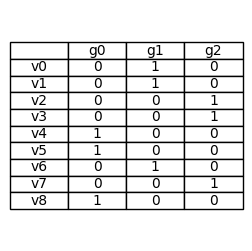

In [105]:
# Show the result
fig, ax = plt.subplots(figsize=(len(G), len(V) / 3))
ax.axis("tight")
ax.axis("off")
table_data = []
for i, row in enumerate(rows):
    table_data.append([labels_row[i]] + list(row))

ax.table(
    cellText=table_data, colLabels=[""] + labels_col, cellLoc="center", loc="center"
)
plt.show()
